# Part 4 - Integrate Multiple Sources

In this notebook we will integrate the preaggregated NYC taxi trips data with the weather data and with the holiday data. This will give us a data set rich of additional features which can be used for the final machine learning task.

The enriched data containing information from multiple independent sources (taxi trips, weather and holidays) will be stored into the *integrated zone*.

In [1]:
dwh_basedir = "/user/hadoop/nyc-dwh"
structured_basedir = dwh_basedir + "/structured"
refined_basedir = dwh_basedir + "/refined"
integrated_basedir = dwh_basedir + "/integrated"

# 0. Setup Environment

## 0.1 Spark Session

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","64G") \
        .getOrCreate()

spark.version

'2.4.4'

## 0.2 Matplotlib

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 0.3 Geopandas and friends

In [4]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

# Helper function to fetch background map tiles
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# 1. Read Taxi Data

Now we can read in the hourly preaggregated taxi data from the refined zone.

In [5]:
taxi_aggregates = spark.read.parquet(refined_basedir + "/taxi-trips-hourly")
taxi_aggregates.limit(10).toPandas()

,date,hour,lat_idx,long_idx,trip_count,passenger_count,fare_amount,tip_amount,total_amount
0,2013-05-14,11,0,0,819,1365,13367.00,1629.74,15517.86
1,2013-12-14,12,1,0,2073,3545,20639.00,2346.26,24105.90
2,2013-01-15,10,3,2,3058,5020,29806.00,3023.74,34512.34
3,2013-06-14,12,3,1,4144,7029,50263.50,5426.97,59020.75
4,2013-03-07,13,2,0,1261,1942,12941.00,1587.16,15321.33
5,2013-11-21,7,2,0,1021,1625,10500.50,1387.19,12589.51
6,2013-09-04,14,4,6,278,513,8446.75,854.23,10407.81
7,2013-11-23,11,2,1,4452,7617,47555.00,4575.15,55024.92
8,2013-08-06,9,2,0,1453,2399,15291.50,1895.13,18062.59
9,2013-11-25,12,1,1,1115,1733,12659.00,1345.20,14694.06


## 1.1 NYC Taxi Trip location

We now also load the taxi trips from the refined zone containing individual records per taxi trip. We use this data to calculate the average geo location of all taxi trips. To clean up the data, we reuse the quantiles previously calculated of the geo locations.

In [6]:
# 95% quantiles of the pickup geo location, as calculated in the previous notebook
min_pickup_longitude=-74.007629
max_pickup_longitude=-73.77668
min_pickup_latitude=40.705612
max_pickup_latitude=40.840221

Now we calculate the average pickup geo location.

In [7]:
taxi_trips = spark.read.parquet(refined_basedir + "/taxi-trip")
result = taxi_trips\
    .filter((taxi_trips["pickup_longitude"] > min_pickup_longitude) & (taxi_trips["pickup_longitude"] < max_pickup_longitude)) \
    .filter((taxi_trips["pickup_latitude"] > min_pickup_latitude) & (taxi_trips["pickup_latitude"] < max_pickup_latitude)) \
    .select(
        f.avg(taxi_trips["pickup_longitude"]).alias("avg_pickup_longitude"),
        f.avg(taxi_trips["pickup_latitude"]).alias("avg_pickup_latitude")
    )

first_result = result.first()
avg_pickup_longitude = first_result["avg_pickup_longitude"]
avg_pickup_latitude = first_result["avg_pickup_latitude"]

print("avg_pickup_latitude=" + str(avg_pickup_latitude))
print("avg_pickup_longitude=" + str(avg_pickup_longitude))

avg_pickup_latitude=40.75499213088766
avg_pickup_longitude=-73.97701325073918


# 2. Weather Data

Now load in the preaggregated hourly and daily weather data from 2013. We will try to find the weather station nearest to the average pickup location.

In [8]:
hourly_weather = spark.read.parquet(refined_basedir + "/weather-hourly/2013")
daily_weather = spark.read.parquet(refined_basedir + "/weather-daily/2013")

## 2.1 Station Master Data

In order to find an appropriate weather station (which will be used for all taxi trips, since we only analyze data from NYC), we use the weather station master data, which also contains the geo location of every weather station.

In [9]:
weather_stations = spark.read.parquet(structured_basedir + "/weather-stations")
weather_stations.limit(10).toPandas()

,USAF,WBAN,STATION_NAME,CTRY,STATE,ICAO,LAT,LON,ELEVATION,BEGIN,END
0,007005,99999,CWOS 07005,None,None,None,None,None,None,20120127,20120127
1,007011,99999,CWOS 07011,None,None,None,None,None,None,20111025,20121129
2,007018,99999,WXPOD 7018,None,None,None,+00.000,+000.000,+7018.0,20110309,20130730
3,007025,99999,CWOS 07025,None,None,None,None,None,None,20120127,20120127
4,007026,99999,WXPOD 7026,AF,None,None,+00.000,+000.000,+7026.0,20120713,20141120
5,007034,99999,CWOS 07034,None,None,None,None,None,None,20121024,20121106
6,007037,99999,CWOS 07037,None,None,None,None,None,None,20111202,20121125
7,007044,99999,CWOS 07044,None,None,None,None,None,None,20120127,20120127
8,007047,99999,CWOS 07047,None,None,None,None,None,None,20120613,20120717
9,007052,99999,CWOS 07052,None,None,None,None,None,None,20121129,20121130


## 2.2 Find Corresponding Weather Station

Using the master data of all weather stations, we now try to find a station which is near to the center of all taxi trips.

In [10]:
nyc_station = weather_stations\
    .filter((weather_stations["BEGIN"] <= "20130101") & ((weather_stations["END"] >= "20131231") | weather_stations["END"].isNull())) \
    .filter(weather_stations["WBAN"] != "99999") \
    .select(
        "*",
        (f.pow(avg_pickup_longitude - weather_stations["LON"],2) + f.pow(avg_pickup_latitude - weather_stations["LAT"],2)).alias("geo_distance")
    ) \
    .filter(f.col("geo_distance").isNotNull()) \
    .orderBy(f.col("geo_distance")) \
    .first()

nyc_station_usaf = nyc_station["USAF"]
nyc_station_wban = nyc_station["WBAN"]
nyc_station_longitude = float(nyc_station["LON"])
nyc_station_latitude = float(nyc_station["LAT"])

print(nyc_station) 
print(nyc_station["LAT"] + "," + nyc_station["LON"])

Row(USAF='725053', WBAN='94728', STATION_NAME='CENTRAL PARK', CTRY='US', STATE='NY', ICAO='KNYC', LAT='+40.779', LON='-073.969', ELEVATION='+0039.6', BEGIN='20120801', END='20151122', geo_distance=0.000640589966724532)
+40.779,-073.969


### Sanity Check

The code above should give us the following weather station:

* USAF='725053'
* WBAN='94728'
* STATION NAME='CENTRAL PARK'
* CTRY='US'
* STATE='NY'
* LAT='+40.779'
* LON='-073.969'

Please make sure to continue with these values, as the following code is tailored for specifically that weather station!

In [11]:
nyc_station_usaf = "725053"
nyc_station_wban = "94728"
nyc_station_latitude = 40.779
nyc_station_longitude = -73.969

### Visualization

Let's make a picture again, showing the average geo coordinate of our data and the weather station. They should match pretty well!

In [12]:
geo_min_x=-8239719.95065924
geo_max_x=-8212678.623952549
geo_min_y=4968029.278728969
geo_max_y=4989775.66725539

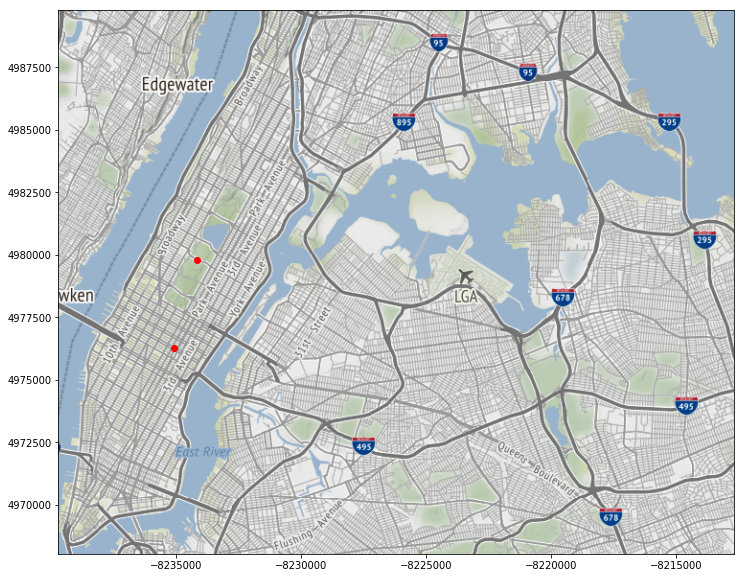

In [13]:
df = pd.DataFrame({
    'LAT'  :[avg_pickup_latitude, nyc_station_latitude],
    'LONG' :[avg_pickup_longitude, nyc_station_longitude]
})

# Convert DataFrame to GeoDataFrame  
coords = pd.Series(zip(df["LONG"], df["LAT"]))
geo_df = gpd.GeoDataFrame(df, crs = {'init': 'epsg:4326'}, geometry = coords.apply(Point)).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(figsize=(15, 10), alpha=1, color="red")
ax.set(ylim=(geo_min_y, geo_max_y), xlim=(geo_min_x, geo_max_x))

# Add basemap below
add_basemap(ax, 12)

# 3. Holidays

The last data set that we want to integrate is the list of bank holidays.

In [14]:
holidays = spark.read.parquet(structured_basedir + "/holidays")
holidays.limit(10).toPandas()

,id,date,description,bank_holiday
0,1,2012-01-02,New Year Day,True
1,2,2012-01-16,Martin Luther King Jr. Day,True
2,3,2012-02-20,Presidents Day (Washingtons Birthday),True
3,4,2012-05-28,Memorial Day,True
4,5,2012-07-04,Independence Day,True
5,6,2012-09-03,Labor Day,True
6,7,2012-10-08,Columbus Day,True
7,8,2012-11-12,Veterans Day,True
8,9,2012-11-22,Thanksgiving Day,True
9,10,2012-12-25,Christmas Day,True


In [15]:
holidays.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- description: string (nullable = true)
 |-- bank_holiday: boolean (nullable = true)



# 4. Join Data

Finally we join together all four data sets:
* Preaggregated taxi trips
* Hourly weather data
* Daily weather data
* Holidays

### NYC Weather

We filter the weather data to the NYC weather station.

In [16]:
nyc_daily_weather = daily_weather.filter((daily_weather["usaf"] == nyc_station_usaf) & (daily_weather["wban"] == nyc_station_wban)).cache()
nyc_hourly_weather = hourly_weather.filter((hourly_weather["usaf"] == nyc_station_usaf) & (hourly_weather["wban"] == nyc_station_wban)).cache()

### Join Data Sets

Now we carefully join all enrichment information to the preaggregated hourly taxi trips.

In [17]:
all_data = taxi_aggregates \
    .join(f.broadcast(holidays), ["date"], how="leftOuter") \
    .drop(holidays["date"]) \
    .drop(holidays["id"]) \
    .withColumnRenamed("description", "holiday_description") \
    .join(f.broadcast(nyc_hourly_weather), ["date", "hour"], how="leftOuter") \
    .withColumnRenamed("precipitation", "hourly_precipitation") \
    .withColumnRenamed("wind_speed", "hourly_wind_speed") \
    .withColumnRenamed("temperature", "hourly_temperature") \
    .drop(nyc_hourly_weather["date"])\
    .drop(nyc_hourly_weather["hour"]) \
    .drop(nyc_hourly_weather["usaf"])\
    .drop(nyc_hourly_weather["wban"])\
    .join(f.broadcast(nyc_daily_weather), ["date"], how="leftOuter") \
    .withColumnRenamed("precipitation", "daily_precipitation") \
    .withColumnRenamed("wind_speed", "daily_wind_speed") \
    .withColumnRenamed("temperature", "daily_temperature") \
    .drop(nyc_daily_weather["date"])\
    .drop(nyc_daily_weather["usaf"])\
    .drop(nyc_daily_weather["wban"])\
    .orderBy("date", "hour") \
    .cache()

all_data.limit(10).toPandas()

,date,hour,lat_idx,long_idx,trip_count,passenger_count,fare_amount,tip_amount,total_amount,holiday_description,bank_holiday,hourly_wind_speed,hourly_temperature,hourly_precipitation,daily_temperature,daily_wind_speed,daily_precipitation
0,2013-01-01,0,3,8,2,2,9.0,0.00,11.00,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
1,2013-01-01,0,-1,2,1372,2539,17674.5,1443.41,20591.90,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
2,2013-01-01,0,3,1,2872,5512,39267.5,2457.05,44834.95,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
3,2013-01-01,0,4,2,2202,4199,24053.0,2142.40,28443.00,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
4,2013-01-01,0,1,-1,3,7,124.0,17.65,150.90,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
5,2013-01-01,0,1,9,1,1,51.0,0.00,52.00,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
6,2013-01-01,0,4,-1,3,5,93.0,0.00,95.50,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
7,2013-01-01,0,0,1,145,285,2040.0,225.00,2409.50,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
8,2013-01-01,0,0,5,2,2,17.0,0.00,19.00,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0
9,2013-01-01,0,2,5,29,60,429.5,9.70,473.00,New Year Day,True,4.1,2.8,0.0,3.241667,3.156522,0.0


### Write to Integrated Zone

The result will be written into the integrated zone into the sub directory `taxi-trips-hourly`.

In [18]:
all_data.write.mode("overwrite").parquet(integrated_basedir + "/taxi-trips-hourly")

In [19]:
all_data = spark.read.parquet(integrated_basedir + "/taxi-trips-hourly")
all_data.limit(10).toPandas()

,date,hour,lat_idx,long_idx,trip_count,passenger_count,fare_amount,tip_amount,total_amount,holiday_description,bank_holiday,hourly_wind_speed,hourly_temperature,hourly_precipitation,daily_temperature,daily_wind_speed,daily_precipitation
0,2013-04-12,14,3,6,288,543,9675.00,1012.03,11950.14,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
1,2013-04-12,14,2,2,238,399,3206.00,334.43,3765.53,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
2,2013-04-12,14,3,8,2,7,15.50,5.00,21.50,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
3,2013-04-12,14,-1,-1,838,1349,21554.16,1918.80,24907.67,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
4,2013-04-12,14,4,2,2900,5108,28534.00,2513.39,32720.89,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
5,2013-04-12,14,4,3,520,895,5617.00,517.76,6464.05,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
6,2013-04-12,14,2,3,29,33,829.50,37.25,907.99,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
7,2013-04-12,14,3,2,3322,5455,36235.50,3674.56,41991.23,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
8,2013-04-12,14,2,-1,3,3,30.00,3.00,34.50,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667
9,2013-04-12,14,2,7,4,4,145.00,10.00,162.33,None,None,4.475,5.0,17.0,6.655347,4.985507,78.216667


# 5. Pictures

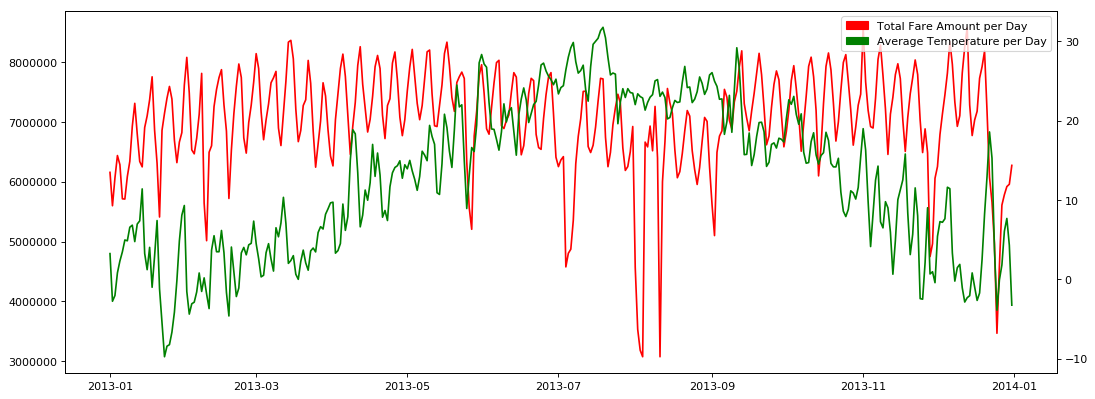

In [20]:
daily = all_data \
    .groupBy("date").agg(
        f.sum("total_amount").alias("amount"),
        f.avg("hourly_temperature").alias("temperature"),
    )\
    .orderBy("date")

# Convert to Pandas    
pdf = daily.toPandas()

fig, ax1 = plt.subplots(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

# Plot fare amount
ax1.plot(pdf["date"],pdf["amount"], color="red")

# Plot temperature
ax2 = ax1.twinx() 
ax2.plot(pdf["date"],pdf["temperature"], color="green")

# Plot legends
plt.legend(handles=[
    mpatches.Patch(color='red', label='Total Fare Amount per Day'),
    mpatches.Patch(color='green', label='Average Temperature per Day')
])